We will introduce the following "engineering improvements" which are missing between REINFORCE and PPO but are not explicitly part of the algorithm:

- Adam instead of SGD.
- Gradient update once per episode with gradients of each step accumulated, rather than updating the policy once per time step.
- (TBD scaling observations / actions / rewards to make different environments comparable.)

### Summary of changes

* With Adam (and default parameters) instead of SGD, and the same parameters from before (gamma = 0.9995, alpha = 8e-06, alpha_value = 4e-05), I got around 90 total reward over the last 100 episodes after 14'000 episodes of training. The total reward per episode does however not collapse at that point, and training can be continued to get 140 reward over the last 100 episodes after 28'000 episodes of training, an average of 180 after 42k episodes, and then seems to stabilize. With these parameters, the LunarLander environment does not seem to get solved (average reward over 100 episodes never exceeds 200).
  
  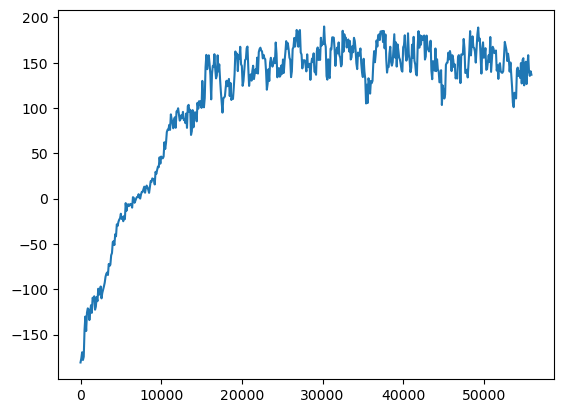

* With Adam and one update per episode, rather than one update per step, the environment was solved (average of total episode rewards over 100 subsequent episode exceeded the environment threshold) for parameters alpha = 0.001, alpha_value = 1e-05, gamma 0.999. During the training, however, the total reward per episode jumps around. While the environment was solved during training with two big spikes in rewards at around 18k and 34k episodes, the overall training progress is not monotonic and does not seem to be desirable.

  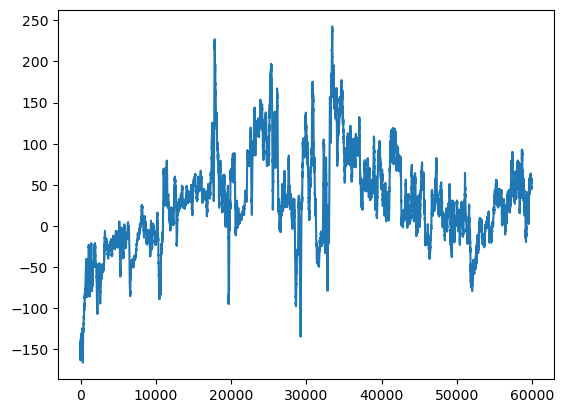

In [1]:
import gymnasium as gym

import numpy as np

import torch
from torch import nn

In [2]:
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )
        self.sm = nn.Softmax(dim=0) # probabilities to choose an action
        self.lsm = nn.LogSoftmax(dim=0) # for log probabilities used in the gradient for REINFORCE
    
    def forward(self, x): 
        logits = self.net(x)
        probs = self.sm(logits)
        scores = self.lsm(logits)
        return probs, scores, logits # we include the logits in the output for use in the state-value function

In [3]:
seed = 42
env_name = "LunarLander-v3"

# We follow the specification of PPO: 
# "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units, and tanh nonlinearities [...]
# applied to discrete actions (PPO uses continuous actions)
n_hidden1 = 64 
n_hidden2 = 64
gamma = 0.999

# Sutton & Barto use a separate learning rate to update the state-value function parameters
alpha_value = 1e-5
alpha = 1e-3

n_episodes = 60_000
print_every_n_episodes = 500

early_stopping = False

In [4]:
# def fun(
#     seed,
#     env_name,
#     n_hidden1,
#     n_hidden2,
#     gamma,
#     alpha,
#     alpha_value,
#     n_episodes,
#     print_every_n_episodes,
#     early_stopping
#     ):
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False)

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.n)

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=1)

# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
# Change 1: Adam with default parameters instead of SGD
optimizer = torch.optim.Adam(policy.parameters(), lr=alpha, maximize=True)
optimizer_value = torch.optim.Adam(value.parameters(), lr=alpha_value, maximize=True)


all_episode_rewards = []

for i_episode in range(1, n_episodes+1):
    
    rewards = [] # T rewards from 1 to T
    observations = [observation] # T observations from 0 to T-1, the policy expects tensors as input
    actions = [] # T actions from 0 to T-1

    # roll-out of one episode following the policy
    done = False
    while not done:
        
        # probabilities for actions, we use the probabilities (softmax) here, and the score (log softmax) later for the gradient
        pred_probab, pred_score, policy_logits = policy(observation)
        
        # sample an action according to the probabilities
        action = np.random.choice(len(pred_probab), 1, p=pred_probab.detach().numpy()) 

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.item())
        observation = torch.tensor(observation, requires_grad=False) # TODO: check that environment returns tensors, or policy converts input in forward
        done = terminated or truncated

        # build up one episode
        rewards.append(reward)
        observations.append(observation)
        actions.append(action)

        # If the episode has ended then we can reset to start a new episode
        if done:
            observation, info = env.reset()
            all_episode_rewards.append(sum(rewards)) # track total reward for all episodes

    
    # policy updates using policy gradients along each step of the episode
    # Change 2: We accumulate gradients over one episode and make only one gradient step per episode
    pseudo_losses = []
    value_losses = []
    for t in range(len(rewards)):
        
        # observation at step t during episode, and action taken
        observation = observations[t]
        action = actions[t] 
        
        # discounted return starting from step t
        G = sum(gamma**i * r for i, r in enumerate(rewards[t:]))
        
        # removing the baseline
        _, _, value_logit = value(observation)
        delta = G - value_logit
        
        # note that delta does not only depend on the rewards (through G), but also on the parameters of the state-value network (through the value logits)
        # note however, that we don't take the gradient of them
        delta = delta.detach()

        # this is the probability but under the policy that was updated along the episode # TODO don't need to recalculate this as the policy is no longer updated along the episode
        pred_probab, pred_score, policy_logits = policy(observation)

        # but we want the updated probability of the action that was actually taken # TODO check this, don't need to recalculate this as the policy is no longer updated along the episode
        log_pi_at_st_theta = pred_score[action] 

        # Change 2: We accumulate gradients over one episode and make only one gradient step per episode
        pseudo_losses.append(gamma**t * delta * log_pi_at_st_theta) # replaced G by delta = G - value function
        value_losses.append(delta * value_logit)
    
    # Change 2: We accumulate gradients over one episode and make only one gradient step per episode
    pseudo_loss = torch.stack(pseudo_losses).mean()
    value_pseudo_loss = torch.stack(value_losses).mean()
    
    # We now include a gradient step of the value function
    optimizer_value.zero_grad()
    value_pseudo_loss.backward()
    optimizer_value.step()

    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()
    

    # print some statistics every other episode
    if i_episode % print_every_n_episodes == 0:
        print("\nEpisode:", i_episode, "of", n_episodes)
        print("Alpha:", alpha, "Alpha_value:", alpha_value, "Gamma", gamma)
        print("Total reward in this episode:", sum(rewards))
        print("State-value function for initial observation in this episode:", value(observations[0])[2].item())
        if len(all_episode_rewards) > 100: print("Average reward last 100 episodes:", np.mean(all_episode_rewards[-100:]))

    if early_stopping and i_episode > 5000 and np.mean(all_episode_rewards[-200:]) < -100:
        print("Run terminated due to early stopping at episode", i_episode)
        break

# - When a policy solved the environment for one episode:
    # if all_episode_rewards[-1] > env.spec.reward_threshold:
    #     print("Environment was solved for one episode at episode", i_episode)
    
    if early_stopping and len(all_episode_rewards) >= 100 and np.mean(all_episode_rewards[-100:]) > env.spec.reward_threshold:
        print("Policy solved environment for last 100 episodes, early stopping, at episode", i_episode)
        break

env.close()
    
    # if len(all_episode_rewards) > 100: return(np.mean(all_episode_rewards[-100:]))


Episode: 500 of 60000
Alpha: 0.001 Alpha_value: 1e-05 Gamma 0.999
Total reward in this episode: -142.8760778110498
State-value function for initial observation in this episode: -0.060567282140254974
Average reward last 100 episodes: -119.69101065001132

Episode: 1000 of 60000
Alpha: 0.001 Alpha_value: 1e-05 Gamma 0.999
Total reward in this episode: 15.443597052913816
State-value function for initial observation in this episode: -0.17651724815368652
Average reward last 100 episodes: -71.67892924461137

Episode: 1500 of 60000
Alpha: 0.001 Alpha_value: 1e-05 Gamma 0.999
Total reward in this episode: 14.357843759474747
State-value function for initial observation in this episode: -0.20543015003204346
Average reward last 100 episodes: -33.85111358521454

Episode: 2000 of 60000
Alpha: 0.001 Alpha_value: 1e-05 Gamma 0.999
Total reward in this episode: -34.29092814474289
State-value function for initial observation in this episode: -0.49079158902168274
Average reward last 100 episodes: -23.31

### Save and load trained policies

In [ ]:
import pickle

# Uncomment to save a trained policy:
# pickle.dump(policy, open('policies/REINFORCE_eng_impr_Adam_1update_per_episode_60k.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('../policies/REINFORCE_with_baseline_LunarLander_best.pkl', 'rb'))

### Plotting training progress

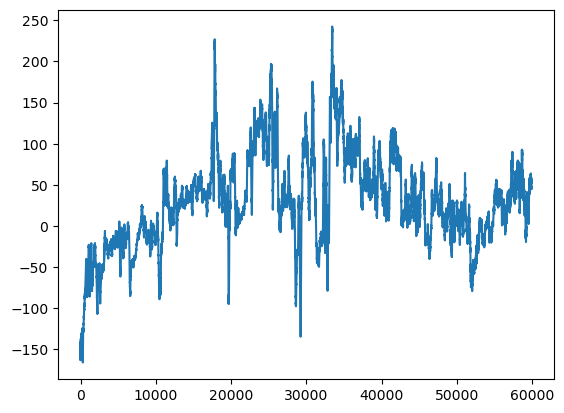

In [5]:
import matplotlib.pyplot as plt
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')

plt.plot(smoothed_rewards)

## Visualize the policy


In [ ]:
# Initialise the environment
env = gym.make(env_name, render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

done = False
total_reward = 0
while not done:

    pred_probab, pred_score, _ = policy(torch.tensor(observation, requires_grad=False))
    action = pred_probab.argmax()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.item())
    total_reward += reward

    # If the episode has ended then we can reset to start a new episode
    done = terminated or truncated
    if done:
        observation, info = env.reset()

env.close()
print(total_reward)

208.13092141624787


## Optional: Hyperparameter search in parallel

Even with just a few parameters (two different learning rates for policy and state-value function, and the discount factor), manually finding good values for them becomes tedious. 

Here is a potential approach to do grid search for many parameter combinations in parallel. It works by encapsulating the training cell above in a function.

For this approach, the main training cell above needs to be modified to be made a function depending on the hyperparameters:

In [ ]:
# Add this as first lines in the training cell above for parallel runs and indent everything once:
def fun(
    seed,
    env_name,
    n_hidden1,
    n_hidden2,
    gamma,
    alpha,
    alpha_value,
    n_episodes,
    print_every_n_episodes
    ):

# You can return something, e.g., the average reward over the last 100 training steps (add this as last line):
    if len(all_episode_rewards) > 100: return(np.mean(all_episode_rewards[-100:]))

Then a helper script can be invoked taking as input a dictionary of the form `{parameter_name: list with values to try}`.

For example:

In [ ]:
import utils.trainparallel

params = {
    "seed" : [42],
    "env_name" : ["LunarLander-v3"],
    "n_hidden1" : [64],
    "n_hidden2" : [64],
    "gamma" : [0.999, 0.9995],
    "alpha" : [0.002, 0.001, 0.0009, 0.0008],
    "alpha_value" : [2e-5, 1e-5, 9e-6, 8e-6],
    "n_episodes" : [20_000],
    "print_every_n_episodes" : [500],
    "early_stopping": [True]
}
result = utils.trainparallel.trainparallel(fun, params, processes=6)
print(result)

Starting 32 runs!



Starting run 8 with input: {'seed': 42, 'env_name': 'LunarLander-v3', 'n_hidden1': 64, 'n_hidden2': 64, 'gamma': 0.999, 'alpha': 0.0009, 'alpha_value': 2e-05, 'n_episodes': 20000, 'print_every_n_episodes': 500, 'early_stopping': True}Starting run 2 with input: {'seed': 42, 'env_name': 'LunarLander-v3', 'n_hidden1': 64, 'n_hidden2': 64, 'gamma': 0.999, 'alpha': 0.002, 'alpha_value': 9e-06, 'n_episodes': 20000, 'print_every_n_episodes': 500, 'early_stopping': True}Starting run 10 with input: {'seed': 42, 'env_name': 'LunarLander-v3', 'n_hidden1': 64, 'n_hidden2': 64, 'gamma': 0.999, 'alpha': 0.0009, 'alpha_value': 9e-06, 'n_episodes': 20000, 'print_every_n_episodes': 500, 'early_stopping': True}Starting run 0 with input: {'seed': 42, 'env_name': 'LunarLander-v3', 'n_hidden1': 64, 'n_hidden2': 64, 'gamma': 0.999, 'alpha': 0.002, 'alpha_value': 2e-05, 'n_episodes': 20000, 'print_every_n_episodes': 500, 'early_stopping': True}Starting run 6 with input: {'seed': 42, 'env_name': 'LunarLander-